# Imports

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import datetime
import json
import os
import sys

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import ipywidgets as widgets
from matplotlib import gridspec
import matplotlib.image as mpimg
from scipy.signal import hilbert, filtfilt, find_peaks, lfilter

project_root = '..'
sys.path.append(project_root)

from sleeprnn.data.inta_ss import IntaSS, NAMES
from sleeprnn.data import utils, stamp_correction
from sleeprnn.detection import metrics
from sleeprnn.helpers import reader, misc, plotter
from sleeprnn.common import constants, pkeys, viz

%matplotlib inline

viz.notebook_full_width()

# Load data

In [3]:
# Load dataset
dataset = IntaSS(load_checkpoint=True)
dataset_name = dataset.dataset_name
fs = dataset.fs
marked_channel = 'F4-C4'

# Load predictions
ckpt_folder = os.path.join('20190706_inta_05_n2_train_inta_ss', 'v15')
predictions_dict = reader.read_prediction_with_seeds(ckpt_folder, dataset_name, constants.N2_RECORD)
optimal_thr_list = [0.42, 0.44, 0.48, 0.5]
print('Optimal thr:', optimal_thr_list)

Train size: 7. Test size: 3
Train subjects: 
 [1, 2, 4, 6, 8, 10, 11]
Test subjects: 
 [5, 7, 9]
Dataset inta_ss with 10 patients.
Loading from checkpoint... Loaded
Global STD: 39.144096
Loading predictions from /home/ntapia/Projects/GitNico/sleep-rnn/results/predictions_inta_ss/20190706_inta_05_n2_train_inta_ss/v15
Loaded seed 1 / 4
Loaded seed 2 / 4
Loaded seed 3 / 4
Loaded seed 4 / 4
Optimal thr: [0.42, 0.44, 0.48, 0.5]


# Choose subject

In [4]:
# Load stamps of subject
subject_id = 8
filter_eeg_broad_band = True

print('Loading S%02d' % subject_id)

path_stamps = os.path.join(dataset.dataset_dir, 'label/spindle', 'SS_%s.txt' % NAMES[subject_id - 1])
path_signals = os.path.join(dataset.dataset_dir, 'register', '%s.rec' % NAMES[subject_id - 1]) 

signal_dict = reader.read_signals_from_edf(path_signals)
signal_names = list(signal_dict.keys())
to_show_names = misc.get_inta_eeg_names(signal_names) + misc.get_inta_eog_emg_names(signal_names)
for single_name in misc.get_inta_eeg_names(signal_names):
    this_signal = signal_dict[single_name]
    if filter_eeg_broad_band:
        print('Filtering %s channel' % single_name)
        this_signal = utils.broad_filter(this_signal, fs)
    signal_dict[single_name] = this_signal

raw_stamps_1, raw_stamps_2 = reader.load_raw_inta_stamps(path_stamps, path_signals, min_samples=20, chn_idx=0)

durations_1 = (raw_stamps_1[:, 1] - raw_stamps_1[:, 0]) / fs
durations_2 = (raw_stamps_2[:, 1] - raw_stamps_2[:, 0]) / fs
print('V1', raw_stamps_1.shape, 'Min dur [s]', durations_1.min(), 'Max dur [s]', durations_1.max())
print('V2', raw_stamps_2.shape, 'Min dur [s]', durations_2.min(), 'Max dur [s]', durations_2.max())

overlap_m = utils.get_overlap_matrix(raw_stamps_1, raw_stamps_1)
groups_overlap_1 = utils.overlapping_groups(overlap_m)
overlap_m = utils.get_overlap_matrix(raw_stamps_2, raw_stamps_2)
groups_overlap_2 = utils.overlapping_groups(overlap_m)

n_overlaps_1 = [len(single_group) for single_group in groups_overlap_1]
values_1, counts_1 = np.unique(n_overlaps_1, return_counts=True)
print('\nSize of overlapping groups for Valid 1')
for value, count in zip(values_1, counts_1):
    print('%d marks: %d times' % (value, count))

n_overlaps_2 = [len(single_group) for single_group in groups_overlap_2]
values_2, counts_2 = np.unique(n_overlaps_2, return_counts=True)
print('\nSize of overlapping groups for Valid 2')
for value, count in zip(values_2, counts_2):
    print('%d marks: %d times' % (value, count))

max_overlaps = np.max([values_1.max(), values_2.max()]) - 1

Loading S08
Filtering F4-C4 channel
Filtering C4-O2 channel
Filtering F3-C3 channel
Filtering C3-O1 channel
Filtering C4-C3 channel
Using F4-C4 channel
End time < Start time fixed
Zero duration stamp found and removed
End time < Start time fixed
Stamp with too few samples removed (14)
Stamp with too few samples removed (9)
Stamp with too many samples removed (1481)
V1 (1404, 2) Min dur [s] 0.115 Max dur [s] 5.81
V2 (775, 2) Min dur [s] 0.285 Max dur [s] 5.025

Size of overlapping groups for Valid 1
1 marks: 1398 times
2 marks: 3 times

Size of overlapping groups for Valid 2
1 marks: 579 times
2 marks: 73 times
3 marks: 14 times
4 marks: 2 times


This pages (1753,)
This stamps (1371, 2)


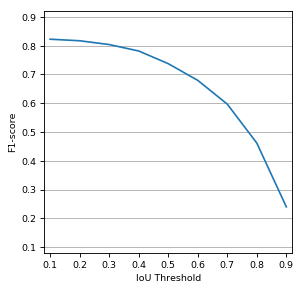

In [5]:
if subject_id != 3:
    subject_seed_set_dict = {
        1: (2, constants.VAL_SUBSET),
        2: (1, constants.VAL_SUBSET),
        4: (0, constants.VAL_SUBSET),
        5: (0, constants.TEST_SUBSET),
        6: (1, constants.VAL_SUBSET),
        7: (0, constants.TEST_SUBSET),
        8: (3, constants.VAL_SUBSET),
        9: (0, constants.TEST_SUBSET),
        10: (2, constants.VAL_SUBSET),
        11: (0, constants.VAL_SUBSET),
    }

    this_pages = dataset.get_subject_pages(subject_id=subject_id) 
    this_stamps = dataset.get_subject_stamps(subject_id=subject_id)
    print('This pages', this_pages.shape)
    print('This stamps', this_stamps.shape)

    # Model predictions
    iou_list = np.arange(1, 10) * 0.1
    f1_vs_iou_list = []
    this_seed = subject_seed_set_dict[subject_id][0]
    set_name = subject_seed_set_dict[subject_id][1]
    prediction_obj = predictions_dict[this_seed][set_name]
    prediction_obj.set_probability_threshold(optimal_thr_list[this_seed])
    this_detections = prediction_obj.get_subject_stamps(subject_id=subject_id)
    f1_vs_iou = metrics.metric_vs_iou(
        this_stamps, this_detections, iou_list)
    fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=80)
    ax.plot(iou_list, f1_vs_iou)
    ax.set_xlim([0.1 - 0.02, 0.9 + 0.02])
    ax.set_ylim([0.1 - 0.02, 0.9 + 0.02])
    ax.set_yticks([0.1*i for i in range(1, 10)])
    ax.set_xticks([0.1*i for i in range(1, 10)])
    ax.tick_params(labelsize=8.5)
    ax.set_xlabel('IoU Threshold', fontsize=8.5)
    ax.set_ylabel('F1-score', fontsize=8.5)
    ax.yaxis.grid()
    plt.show()
else:
    this_pages = np.arange(1, signal_dict[marked_channel].size//dataset.page_size - 1)
    this_detections = np.array([])

In [58]:
# Replace model with new marks
if subject_id in [11]:
    this_detections = np.loadtxt('mark_files/20190805_Revision_SS_%s.txt' % NAMES[subject_id-1])
    this_detections = this_detections[:, [0, 1]]
else:
    this_detections = np.array([])

# Conflicts

In [6]:
# Select marks without doubt
groups_in_doubt_v1_list = []
groups_in_doubt_v2_list = []

iou_to_accept = 0.8
marks_without_doubt = []
overlap_between_1_and_2 = utils.get_overlap_matrix(raw_stamps_1, raw_stamps_2)

for single_group in groups_overlap_2:
    if len(single_group) == 1:
        marks_without_doubt.append(raw_stamps_2[single_group[0], :])
    elif len(single_group) == 2:
        # check if IOU between marks is close 1, if close, then just choose newer (second one)
        option1_mark = raw_stamps_2[single_group[0], :]
        option2_mark = raw_stamps_2[single_group[1], :]
        iou_between_marks = metrics.get_iou(option1_mark, option2_mark)
        if iou_between_marks >= iou_to_accept:
            marks_without_doubt.append(option2_mark)
        else:
            groups_in_doubt_v2_list.append(single_group)
    else:
        groups_in_doubt_v2_list.append(single_group)
        
for single_group in groups_overlap_1:
    is_in_doubt = False
    # Check if entire group is overlapping
    all_are_overlapping_2 = np.all(overlap_between_1_and_2[single_group, :].sum(axis=1))
    if not all_are_overlapping_2:
        # Consider the mark
        if len(single_group) == 1:
            # Since has size 1 and is no overlapping 2, accept it
            marks_without_doubt.append(raw_stamps_1[single_group[0], :])
        elif len(single_group) == 2:
            # check if IOU between marks is close 1, if close, then just choose newer (second one) since there is no intersection
            option1_mark = raw_stamps_1[single_group[0], :]
            option2_mark = raw_stamps_1[single_group[1], :]
            iou_between_marks = metrics.get_iou(option1_mark, option2_mark)
            if iou_between_marks >= iou_to_accept:
                marks_without_doubt.append(raw_stamps_1[single_group[1], :])
            else:
                is_in_doubt = True
        else:
            is_in_doubt = True
    if is_in_doubt:
        groups_in_doubt_v1_list.append(single_group)

marks_without_doubt = np.stack(marks_without_doubt, axis=0)
marks_without_doubt = np.sort(marks_without_doubt, axis=0)
print('Marks automatically added:', marks_without_doubt.shape)
print('Remaining conflicts:')
print('    V1: %d' % len(groups_in_doubt_v1_list))
print('    V2: %d' % len(groups_in_doubt_v2_list))

Marks automatically added: (1345, 2)
Remaining conflicts:
    V1: 3
    V2: 82


In [7]:
show_complete_conflict_detail = False

conflict_pages = []

if show_complete_conflict_detail:
    print('Conflict detail')
for single_group in groups_in_doubt_v1_list:
    group_stamps = raw_stamps_1[single_group, :]
    min_sample = group_stamps.min()
    max_sample = group_stamps.max()
    center_group = (min_sample + max_sample) / 2
    integer_page = int(center_group / dataset.page_size)
    decimal_part = np.round(2 * (center_group % dataset.page_size) / dataset.page_size) / 2 - 0.5
    page_location = integer_page + decimal_part
    conflict_pages.append(page_location)
    if show_complete_conflict_detail:
        print('V1 - Group of size %d at page %1.1f' % (group_stamps.shape[0], page_location ))

for single_group in groups_in_doubt_v2_list:
    group_stamps = raw_stamps_2[single_group, :]
    min_sample = group_stamps.min()
    max_sample = group_stamps.max()
    center_group = (min_sample + max_sample) / 2
    integer_page = int(center_group / dataset.page_size)
    decimal_part = np.round(2 * (center_group % dataset.page_size) / dataset.page_size) / 2 - 0.5
    page_location = integer_page + decimal_part
    conflict_pages.append(page_location)
    if show_complete_conflict_detail:
        print('V2 - Group of size %d at page %1.1f' % (group_stamps.shape[0], page_location ))
conflict_pages = np.unique(conflict_pages)

print('')
print('Number of pages with conflict %d' % conflict_pages.size)


Number of pages with conflict 82


# Plotter functions

In [15]:
def plot_page(page_chosen, show_model, show_expert, dpi=viz.DPI):
    
    microvolt_per_second = 200  # Aspect ratio
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 1+1.0*len(to_show_names)), dpi=dpi)
    
    page_start = page_chosen * dataset.page_size
    page_end = page_start + dataset.page_size
    
    this_subject_new_accepted = accepted_marks_dict[subject_id]
    this_subject_removed = removed_marks_dict[subject_id]
    
    if show_expert:
        segment_stamps = utils.filter_stamps(marks_without_doubt, page_start, page_end)
        segment_stamps_valid_1 = utils.filter_stamps(raw_stamps_1, page_start, page_end)
        segment_stamps_valid_2 = utils.filter_stamps(raw_stamps_2, page_start, page_end)
    else:
        segment_stamps = []
        segment_stamps_valid_1 = []
        segment_stamps_valid_2 = []
        
    if show_model:
        segment_model_stamps = utils.filter_stamps(this_detections, page_start, page_end)
    else:
        segment_model_stamps = []
    
    time_axis = np.arange(page_start, page_end) / fs
    x_ticks = np.arange(time_axis[0], time_axis[-1]+1, 1)
   
    dy_valid = 40
    
    shown_valid = False
    valid_label = 'Candidate mark'
    
    new_accepted_list = []
    
    # Show valid 1
    valid_start = 0
    shown_groups_1 = []
    for j, this_stamp in enumerate(segment_stamps_valid_1):
        idx_stamp = np.where([np.all(this_stamp == single_stamp) for single_stamp in raw_stamps_1])[0]
        idx_group = np.where([idx_stamp in single_group for single_group in groups_overlap_1])[0][0].item()
        shown_groups_1.append(idx_group)
    shown_groups_1 = np.unique(shown_groups_1)
    max_size_shown = 0
    for single_group in shown_groups_1:
        group_stamps = [raw_stamps_1[single_idx] for single_idx in groups_overlap_1[single_group]]
        group_stamps = np.stack(group_stamps, axis=0)
        group_size = group_stamps.shape[0]
        if group_size > max_size_shown:
            max_size_shown = group_size
        for j, single_stamp in enumerate(group_stamps):
            stamp_idx = int(1 * 1e4 + groups_overlap_1[single_group][j])
            
            if stamp_idx in this_subject_new_accepted:
                color_for_display = viz.PALETTE['blue']
                new_accepted_list.append(single_stamp)
            else:
                color_for_display = viz.PALETTE['red']
            
            ax.plot(single_stamp/fs, [valid_start-j*dy_valid, valid_start-j*dy_valid], color=color_for_display, linewidth=1.5, label=valid_label)
            ax.annotate(stamp_idx, (single_stamp[1]/fs+0.05, valid_start-j*dy_valid-10), fontsize=7)
            shown_valid = True
            valid_label = None
    
    valid_1_center = valid_start - (max_size_shown//2) * dy_valid
    
    # Show valid 2
    valid_start = - max_size_shown * dy_valid - 200
    shown_groups_2 = []
    for j, this_stamp in enumerate(segment_stamps_valid_2):
        idx_stamp = np.where([np.all(this_stamp == single_stamp) for single_stamp in raw_stamps_2])[0]
        idx_group = np.where([idx_stamp in single_group for single_group in groups_overlap_2])[0][0].item()
        shown_groups_2.append(idx_group)
    shown_groups_2 = np.unique(shown_groups_2)
    max_size_shown = 0
    for single_group in shown_groups_2:
        group_stamps = [raw_stamps_2[single_idx] for single_idx in groups_overlap_2[single_group]]
        group_stamps = np.stack(group_stamps, axis=0)
        group_size = group_stamps.shape[0]
        if group_size > max_size_shown:
            max_size_shown = group_size
        for j, single_stamp in enumerate(group_stamps):
            stamp_idx = int(2 * 1e4 + groups_overlap_2[single_group][j])
            
            if stamp_idx in this_subject_new_accepted:
                color_for_display = viz.PALETTE['blue']
                new_accepted_list.append(single_stamp)
            else:
                color_for_display = viz.PALETTE['red']
            
            ax.plot(single_stamp/fs, [valid_start-j*dy_valid, valid_start-j*dy_valid], color=color_for_display, linewidth=1.5, label=valid_label)
            ax.annotate(stamp_idx, (single_stamp[1]/fs+0.05, valid_start-j*dy_valid-10), fontsize=7)
            shown_valid = True
            valid_label = None
    
    valid_2_center = valid_start - (max_size_shown//2) * dy_valid
    
    # Signal
    y_max = 150
    y_sep = 300
    
    start_signal_plot = valid_start - max_size_shown * dy_valid - y_sep
    
    for k, name in enumerate(to_show_names):
        if name == 'F4-C4':
            stamp_center = start_signal_plot-y_sep*k
        segment_fs = fs
        segment_start = int(page_chosen * dataset.page_duration * segment_fs)
        segment_end = int(segment_start + dataset.page_duration * segment_fs)
        segment_signal = signal_dict[name][segment_start:segment_end]
        segment_time_axis = np.arange(segment_start, segment_end) / segment_fs
        ax.plot(
            segment_time_axis, start_signal_plot-y_sep*k + segment_signal, linewidth=1, color=viz.PALETTE['grey'])
    
    plotter.add_scalebar(ax, matchx=False, matchy=False, hidex=False, hidey=False, sizex=1, sizey=100, labelx='1 s', labely='100 uV')
    model_shown = False
    expert_shown = False
    expert_manual_shown = False
    for model_stamp in segment_model_stamps:
        if not model_shown:
            label = 'Model'
        else:
            label = None
        ax.fill_between(
            model_stamp / fs, 100+stamp_center, -100+stamp_center, 
            facecolor=viz.PALETTE['grey'], alpha=0.4,  label=label)
        model_shown = True

    for expert_stamp in segment_stamps:
        # Check if it was removed
        ignore_this_stamp = False
        for single_idx in this_subject_removed:
            if single_idx < 20000:
                single_idx = single_idx - 10000
                stamp_to_remove = raw_stamps_1[single_idx, :]
                if np.all(stamp_to_remove == expert_stamp):
                    ignore_this_stamp = True
            else:
                single_idx = single_idx - 20000
                stamp_to_remove = raw_stamps_2[single_idx, :]
                if np.all(stamp_to_remove == expert_stamp):
                    ignore_this_stamp = True
        
        if not ignore_this_stamp:
            if not expert_shown:
                label = 'Accepted mark (automatic)'
            else:
                label = None
            ax.plot(
                expert_stamp / fs, [stamp_center-50, stamp_center-50], 
                color=viz.PALETTE['green'], linewidth=2, label=label)
            expert_shown = True
        
    for expert_stamp in new_accepted_list:
        if not expert_manual_shown:
            label = 'Accepted mark (manual)'
        else:
            label = None
        ax.plot(
            expert_stamp / fs, [stamp_center-50, stamp_center-50], 
            color=viz.PALETTE['blue'], linewidth=2, label=label)
        expert_manual_shown = True
    
    ticks_valid = [valid_1_center, valid_2_center]
    ticks_signal = [start_signal_plot-y_sep*k for k in range(len(to_show_names))]
    ticklabels_valid = ['V1', 'V2']
    total_ticks = ticks_valid + ticks_signal
    total_ticklabels = ticklabels_valid + to_show_names[:-2] + ['MOR', 'EMG']
    
    ax.set_yticks(total_ticks)
    ax.set_yticklabels(total_ticklabels)
    ax.set_xlim([time_axis[0], time_axis[-1]])
    ax.set_ylim([-y_max - 30 + ticks_signal[-1], 100])
    ax.set_title('Subject %d (%s INTA). Page in record: %1.1f. (intervals of 0.5s are shown).' 
                 % (subject_id, NAMES[subject_id-1], page_chosen), fontsize=10, y=1.05)
    ax.set_xticks(x_ticks)
    ax.set_xticks(np.arange(time_axis[0], time_axis[-1], 0.5), minor=True)
    ax.grid(b=True, axis='x', which='minor')
    ax.tick_params(labelsize=7.5, labelbottom=True ,labeltop=True, bottom=True, top=True)
    ax.set_aspect(1/microvolt_per_second)
    ax.set_xlabel('Time [s]', fontsize=8)

    if model_shown or expert_shown or shown_valid or expert_manual_shown:
        lg = ax.legend(loc='lower left', fontsize=8)
        for lh in lg.legendHandles:
            lh.set_alpha(1.0)
    
    plt.tight_layout()
    plt.show()

In [16]:
def plot_page_conflict(conflict_idx, show_model, show_expert, dpi=viz.DPI):
    
    microvolt_per_second = 200  # Aspect ratio
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 1+len(to_show_names)), dpi=dpi)
    page_chosen = conflict_pages[conflict_idx-1]
    page_start = page_chosen * dataset.page_size
    page_end = page_start + dataset.page_size
    
    this_subject_new_accepted = accepted_marks_dict[subject_id]
    this_subject_removed = removed_marks_dict[subject_id]
    
    if show_expert:
        segment_stamps = utils.filter_stamps(marks_without_doubt, page_start, page_end)
        segment_stamps_valid_1 = utils.filter_stamps(raw_stamps_1, page_start, page_end)
        segment_stamps_valid_2 = utils.filter_stamps(raw_stamps_2, page_start, page_end)
    else:
        segment_stamps = []
        segment_stamps_valid_1 = []
        segment_stamps_valid_2 = []
        
    if show_model:
        segment_model_stamps = utils.filter_stamps(this_detections, page_start, page_end)
    else:
        segment_model_stamps = []
    
    time_axis = np.arange(page_start, page_end) / fs
    x_ticks = np.arange(time_axis[0], time_axis[-1]+1, 1)
   
    dy_valid = 40
    
    shown_valid = False
    valid_label = 'Candidate mark'
    
    new_accepted_list = []
    
    # Show valid 1
    valid_start = 0
    shown_groups_1 = []
    for j, this_stamp in enumerate(segment_stamps_valid_1):
        idx_stamp = np.where([np.all(this_stamp == single_stamp) for single_stamp in raw_stamps_1])[0]
        idx_group = np.where([idx_stamp in single_group for single_group in groups_overlap_1])[0][0].item()
        shown_groups_1.append(idx_group)
    shown_groups_1 = np.unique(shown_groups_1)
    max_size_shown = 0
    for single_group in shown_groups_1:
        group_stamps = [raw_stamps_1[single_idx] for single_idx in groups_overlap_1[single_group]]
        group_stamps = np.stack(group_stamps, axis=0)
        group_size = group_stamps.shape[0]
        if group_size > max_size_shown:
            max_size_shown = group_size
        for j, single_stamp in enumerate(group_stamps):
            stamp_idx = int(1 * 1e4 + groups_overlap_1[single_group][j])
            
            if stamp_idx in this_subject_new_accepted:
                color_for_display = viz.PALETTE['blue']
                new_accepted_list.append(single_stamp)
            else:
                color_for_display = viz.PALETTE['red']
            
            ax.plot(single_stamp/fs, [valid_start-j*dy_valid, valid_start-j*dy_valid], color=color_for_display, linewidth=1.5, label=valid_label)
            ax.annotate(stamp_idx, (single_stamp[1]/fs+0.05, valid_start-j*dy_valid-10), fontsize=7)
            shown_valid = True
            valid_label = None
    
    valid_1_center = valid_start - (max_size_shown//2) * dy_valid
    
    # Show valid 2
    valid_start = - max_size_shown * dy_valid - 200
    shown_groups_2 = []
    for j, this_stamp in enumerate(segment_stamps_valid_2):
        idx_stamp = np.where([np.all(this_stamp == single_stamp) for single_stamp in raw_stamps_2])[0]
        idx_group = np.where([idx_stamp in single_group for single_group in groups_overlap_2])[0][0].item()
        shown_groups_2.append(idx_group)
    shown_groups_2 = np.unique(shown_groups_2)
    max_size_shown = 0
    for single_group in shown_groups_2:
        group_stamps = [raw_stamps_2[single_idx] for single_idx in groups_overlap_2[single_group]]
        group_stamps = np.stack(group_stamps, axis=0)
        group_size = group_stamps.shape[0]
        if group_size > max_size_shown:
            max_size_shown = group_size
        for j, single_stamp in enumerate(group_stamps):
            stamp_idx = int(2 * 1e4 + groups_overlap_2[single_group][j])
            
            if stamp_idx in this_subject_new_accepted:
                color_for_display = viz.PALETTE['blue']
                new_accepted_list.append(single_stamp)
            else:
                color_for_display = viz.PALETTE['red']
            
            ax.plot(single_stamp/fs, [valid_start-j*dy_valid, valid_start-j*dy_valid], color=color_for_display, linewidth=1.5, label=valid_label)
            ax.annotate(stamp_idx, (single_stamp[1]/fs+0.05, valid_start-j*dy_valid-10), fontsize=7)
            shown_valid = True
            valid_label = None
    
    valid_2_center = valid_start - (max_size_shown//2) * dy_valid
    
    # Signal
    y_max = 150
    y_sep = 300
    
    start_signal_plot = valid_start - max_size_shown * dy_valid - y_sep
    
    for k, name in enumerate(to_show_names):
        if name == 'F4-C4':
            stamp_center = start_signal_plot-y_sep*k
        #if name == 'EMG':
        #    continue
        segment_fs = fs
        segment_start = int(page_chosen * dataset.page_duration * segment_fs)
        segment_end = int(segment_start + dataset.page_duration * segment_fs)
        segment_signal = signal_dict[name][segment_start:segment_end]
        segment_time_axis = np.arange(segment_start, segment_end) / segment_fs
        ax.plot(
            segment_time_axis, start_signal_plot-y_sep*k + segment_signal, linewidth=1, color=viz.PALETTE['grey'])
    
    plotter.add_scalebar(ax, matchx=False, matchy=False, hidex=False, hidey=False, sizex=1, sizey=100, labelx='1 s', labely='100 uV')
    model_shown = False
    expert_shown = False
    expert_manual_shown = False
    for model_stamp in segment_model_stamps:
        if not model_shown:
            label = 'Model'
        else:
            label = None
        ax.fill_between(
            model_stamp / fs, 100+stamp_center, -100+stamp_center, 
            facecolor=viz.PALETTE['grey'], alpha=0.4,  label=label)
        model_shown = True

    for expert_stamp in segment_stamps:
        # Check if it was removed
        ignore_this_stamp = False
        for single_idx in this_subject_removed:
            if single_idx < 20000:
                single_idx = single_idx - 10000
                stamp_to_remove = raw_stamps_1[single_idx, :]
                if np.all(stamp_to_remove == expert_stamp):
                    ignore_this_stamp = True
            else:
                single_idx = single_idx - 20000
                stamp_to_remove = raw_stamps_2[single_idx, :]
                if np.all(stamp_to_remove == expert_stamp):
                    ignore_this_stamp = True
        
        if not ignore_this_stamp:
            if not expert_shown:
                label = 'Accepted mark (automatic)'
            else:
                label = None
            ax.plot(
                expert_stamp / fs, [stamp_center-50, stamp_center-50], 
                color=viz.PALETTE['green'], linewidth=2, label=label)
            expert_shown = True
        
    for expert_stamp in new_accepted_list:
        if not expert_manual_shown:
            label = 'Accepted mark (manual)'
        else:
            label = None
        ax.plot(
            expert_stamp / fs, [stamp_center-50, stamp_center-50], 
            color=viz.PALETTE['blue'], linewidth=2, label=label)
        expert_manual_shown = True
    
    ticks_valid = [valid_1_center, valid_2_center]
    ticks_signal = [start_signal_plot-y_sep*k for k in range(len(to_show_names))]
    ticklabels_valid = ['V1', 'V2']
    total_ticks = ticks_valid + ticks_signal
    total_ticklabels = ticklabels_valid + to_show_names[:-2] + ['MOR', 'EMG']
    
    ax.set_yticks(total_ticks)
    ax.set_yticklabels(total_ticklabels)
    ax.set_xlim([time_axis[0], time_axis[-1]])
    ax.set_ylim([-y_max - 30 + ticks_signal[-1], 100])
    ax.set_title('Subject %d (%s INTA). Page in record: %1.1f. (intervals of 0.5s are shown).' 
                 % (subject_id, NAMES[subject_id-1], page_chosen), fontsize=10, y=1.05)
    ax.set_xticks(x_ticks)
    ax.set_xticks(np.arange(time_axis[0], time_axis[-1], 0.5), minor=True)
    ax.grid(b=True, axis='x', which='minor')
    ax.tick_params(labelsize=7.5, labelbottom=True ,labeltop=True, bottom=True, top=True)
    ax.set_aspect(1/microvolt_per_second)
    ax.set_xlabel('Time [s]', fontsize=8)

    if model_shown or expert_shown or shown_valid or expert_manual_shown:
        lg = ax.legend(loc='lower left', fontsize=8)
        for lh in lg.legendHandles:
            lh.set_alpha(1.0)
    
    plt.tight_layout()
    plt.show()

In [17]:
def count_remaining_conflicts(verbose=True):
    new_marks = accepted_marks_dict[subject_id]
    remaining_groups_in_doubt_v1_list = []
    remaining_groups_in_doubt_v2_list = []
    
    # Check v1 group
    for single_group in groups_in_doubt_v1_list:
        group_resolved = False
        for single_new_mark in new_marks:
            if single_new_mark < 20000:
                single_new_mark = single_new_mark - 10000
                if single_new_mark in single_group:
                    group_resolved = True
                    break
        if not group_resolved:
            remaining_groups_in_doubt_v1_list.append(single_group)
    
    # Check v2 group
    for single_group in groups_in_doubt_v2_list:
        group_resolved = False
        for single_new_mark in new_marks:
            if single_new_mark >= 20000:
                single_new_mark = single_new_mark - 20000
                if single_new_mark in single_group:
                    group_resolved = True
                    break
        if not group_resolved:
            remaining_groups_in_doubt_v2_list.append(single_group)
        
    if verbose:
        print('Remaining conflicts discounting groups with accepted marks:')
        print('    V1: %d' % len(remaining_groups_in_doubt_v1_list))
        print('    V2: %d' % len(remaining_groups_in_doubt_v2_list))
    return remaining_groups_in_doubt_v1_list, remaining_groups_in_doubt_v2_list


def get_pages_of_groups(group_list_1, group_list_2, verbose=False):
    pages_list = []
    for single_group in group_list_1:
        group_stamps = raw_stamps_1[single_group, :]
        min_sample = group_stamps.min()
        max_sample = group_stamps.max()
        center_group = (min_sample + max_sample) / 2
        integer_page = int(center_group / dataset.page_size)
        decimal_part = np.round(2 * (center_group % dataset.page_size) / dataset.page_size) / 2 - 0.5
        page_location = integer_page + decimal_part
        pages_list.append(page_location)
    for single_group in group_list_2:
        group_stamps = raw_stamps_2[single_group, :]
        min_sample = group_stamps.min()
        max_sample = group_stamps.max()
        center_group = (min_sample + max_sample) / 2
        integer_page = int(center_group / dataset.page_size)
        decimal_part = np.round(2 * (center_group % dataset.page_size) / dataset.page_size) / 2 - 0.5
        page_location = integer_page + decimal_part
        pages_list.append(page_location)  
    pages_list = np.unique(pages_list)
    
    if verbose:
        for single_page in pages_list:
            print(single_page)

    return pages_list


# Visual validation

In [18]:
accepted_marks_dict = {}  # Accepting marks not automatically accepted
removed_marks_dict = {}  # Removing marks that were automatically accepted

# S11 (pendiente desde conflicto 51)
accepted_marks_dict[8] = [
    
]
removed_marks_dict[8] = [
    
]

# Save in file
date_hour = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
# with open('accepted_marks_dict_%s.json' % date_hour, 'w') as json_file:  
#     json.dump(accepted_marks_dict, json_file)
# with open('removed_marks_dict_%s.json' % date_hour, 'w') as json_file:  
#     json.dump(removed_marks_dict, json_file)
# Updated report
remaining_groups_in_doubt_v1_list, remaining_groups_in_doubt_v2_list = count_remaining_conflicts(verbose=True)
remaining_pages = get_pages_of_groups(remaining_groups_in_doubt_v1_list, remaining_groups_in_doubt_v2_list, verbose=False)
print('Remaining pages: %d' % len(remaining_pages))

Remaining conflicts discounting groups with accepted marks:
    V1: 3
    V2: 82
Remaining pages: 82


In [19]:
start_conflict = 1

show_model = False
show_expert = True
dpi = 180

print('Total conflicting pages: %d' % conflict_pages.size)
style = {'description_width': 'initial'}
layout= widgets.Layout(width='1000px')
widgets.interact(
    lambda conflict_id: plot_page_conflict(conflict_id, show_model, show_expert, dpi=dpi),
    conflict_id=widgets.IntSlider(
        min=1, max=conflict_pages.size, step=1, value=start_conflict, 
        continuous_update=False,
        style=style,
        layout=layout
    ));

Total conflicting pages: 82


interactive(children=(IntSlider(value=1, continuous_update=False, description='conflict_id', layout=Layout(wid…

In [20]:
start_page = 1

show_model = False
show_expert = True
step = 0.5
dpi = 180

style = {'description_width': 'initial'}
layout= widgets.Layout(width='1000px')
widgets.interact(
    lambda page_chosen: plot_page(page_chosen, show_model, show_expert, dpi=dpi),
    page_chosen=widgets.FloatSlider(
        min=this_pages.min(), max=this_pages.max(), step=step, value=start_page, 
        continuous_update=False,
        style=style,
        layout=layout
    ));

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='page_chosen', layout=Layout…

In [14]:
# def plot_page(page_chosen, show_model, show_expert, dpi=viz.DPI):
    
#     microvolt_per_second = 200  # Aspect ratio
    
#     fig = plt.figure(figsize=(12, 0.7*len(to_show_names)+2), dpi=dpi)
#     gs = gridspec.GridSpec(3, 1, height_ratios=[2, 2, 3*len(to_show_names)])
    
#     page_start = page_chosen * dataset.page_size
#     page_end = page_start + dataset.page_size
    
#     if show_expert:
#         segment_stamps = utils.filter_stamps(marks_without_doubt, page_start, page_end)
#         segment_stamps_valid_1 = utils.filter_stamps(raw_stamps_1, page_start, page_end)
#         segment_stamps_valid_2 = utils.filter_stamps(raw_stamps_2, page_start, page_end)
#     else:
#         segment_stamps = []
#         segment_stamps_valid_1 = []
#         segment_stamps_valid_2 = []
        
#     if show_model:
#         segment_model_stamps = utils.filter_stamps(this_detections, page_start, page_end)
#     else:
#         segment_model_stamps = []
    
#     time_axis = np.arange(page_start, page_end) / fs
#     x_ticks = time_axis[0] + np.arange(5, 21, 5)
    
#     gs_idx = 0

#     # Show valid 1
#     delta_y = 0.1
#     ax = fig.add_subplot(gs[gs_idx])
#     shown_groups_1 = []
#     for j, this_stamp in enumerate(segment_stamps_valid_1):
#         idx_stamp = np.where([np.all(this_stamp == single_stamp) for single_stamp in raw_stamps_1])[0]
#         idx_group = np.where([idx_stamp in single_group for single_group in groups_overlap_1])[0][0].item()
#         shown_groups_1.append(idx_group)
#         n_stamps = len(segment_stamps_valid_1)
#         dy_for_stamp = 1/n_stamps
#         ax.plot(this_stamp/fs, [j*dy_for_stamp, j*dy_for_stamp], color=viz.PALETTE['red'], linewidth=1.5)
#     center_list = []
#     size_list = []
#     name_group_list = []
#     shown_groups_1 = np.unique(shown_groups_1)
#     for single_group in shown_groups_1:
#         group_stamps = [raw_stamps_1[single_idx] for single_idx in groups_overlap_1[single_group]]
#         group_stamps = np.stack(group_stamps, axis=0)
#         coverage = [group_stamps.min(), group_stamps.max()]
#         center_list.append(np.mean(coverage) / fs)
#         size_list.append(group_stamps.size)
#         name_group_list.append('idx-%d' % single_group)
    
#     ax.set_xticks(center_list)
#     ax.set_xticklabels(name_group_list, fontsize=8)
#     ax.set_yticks([])
#     ax.set_ylim([-delta_y, 1+delta_y])
#     ax.set_xlim([time_axis[0], time_axis[-1]])
#     ax.set_ylabel('V1', fontsize=8)
#     ax.set_xticks(np.arange(time_axis[0], time_axis[-1], 0.5), minor=True)
#     ax.grid(b=True, axis='x', which='minor')
    
#     # Show valid 2
#     delta_y = 0.1
#     gs_idx = gs_idx + 1
#     ax = fig.add_subplot(gs[gs_idx])
#     shown_groups_2 = []
#     for j, this_stamp in enumerate(segment_stamps_valid_2):
#         idx_stamp = np.where([np.all(this_stamp == single_stamp) for single_stamp in raw_stamps_2])[0]
#         idx_group = np.where([idx_stamp in single_group for single_group in groups_overlap_2])[0][0].item()
#         shown_groups_2.append(idx_group)
#         n_stamps = len(segment_stamps_valid_2)
#         dy_for_stamp = 1/n_stamps
#         ax.plot(this_stamp/fs, [j*dy_for_stamp, j*dy_for_stamp], color=viz.PALETTE['red'], linewidth=1.5)
#     center_list = []
#     size_list = []
#     name_group_list = []
#     shown_groups_2 = np.unique(shown_groups_2)
#     for single_group in shown_groups_2:
#         group_stamps = [raw_stamps_2[single_idx] for single_idx in groups_overlap_2[single_group]]
#         group_stamps = np.stack(group_stamps, axis=0)
#         coverage = [group_stamps.min(), group_stamps.max()]
#         center_list.append(np.mean(coverage) / fs)
#         size_list.append(group_stamps.size)
#         name_group_list.append('idx-%d' % single_group)
    
#     ax.set_xticks(center_list)
#     ax.set_xticklabels(name_group_list, fontsize=8)
#     ax.set_yticks([])
#     ax.set_ylim([-delta_y, 1+delta_y])
#     ax.set_xlim([time_axis[0], time_axis[-1]])
#     ax.set_ylabel('V2', fontsize=8)
#     ax.set_xticks(np.arange(time_axis[0], time_axis[-1], 0.5), minor=True)
#     ax.grid(b=True, axis='x', which='minor')
    
#     # Signal
#     gs_idx = gs_idx + 1
#     y_max = 150
#     y_sep = 200
#     ax = fig.add_subplot(gs[gs_idx])
    
#     for k, name in enumerate(to_show_names):
#         if name == 'F4-C4':
#             stamp_center = -y_sep*k
#         segment_fs = fs
#         segment_start = int(page_chosen * dataset.page_duration * segment_fs)
#         segment_end = int(segment_start + dataset.page_duration * segment_fs)
#         segment_signal = signal_dict[name][segment_start:segment_end]
#         segment_time_axis = np.arange(segment_start, segment_end) / segment_fs
#         ax.plot(
#             segment_time_axis, -y_sep*k + segment_signal, linewidth=1, color=viz.PALETTE['grey'])
    
#     plotter.add_scalebar(ax, matchx=False, matchy=False, hidex=False, hidey=False, sizex=1, sizey=100, labelx='1 s', labely='100 uV')
#     model_shown = False
#     expert_shown = False
#     for model_stamp in segment_model_stamps:
#         if not model_shown:
#             label = 'Model'
#         else:
#             label = None
#         ax.fill_between(
#             model_stamp / fs, 50+stamp_center, -50+stamp_center, 
#             facecolor=viz.PALETTE['green'], alpha=0.4,  label=label)
#         model_shown = True

#     for expert_stamp in segment_stamps:
#         if not expert_shown:
#             label = 'Accepted'
#         else:
#             label = None
#         ax.plot(
#             expert_stamp / fs, [stamp_center-50, stamp_center-50], 
#             color=viz.PALETTE['blue'], linewidth=2, label=label)
#         expert_shown = True
    
#     ax.set_yticks([-y_sep*k for k in range(len(to_show_names))])
#     ax.set_yticklabels(to_show_names)
#     ax.set_xlim([time_axis[0], time_axis[-1]])
#     ax.set_ylim([-y_max -y_sep*(len(to_show_names)-1) - 30, y_max])
#     ax.set_title('Subject %d (%s INTA). Page in record: %1.1f. (intervals of 0.5s are shown).' 
#                  % (subject_id, NAMES[subject_id-1], page_chosen), fontsize=10)
#     ax.set_xticks(x_ticks)
#     ax.set_xticks(np.arange(time_axis[0], time_axis[-1], 0.5), minor=True)
#     ax.grid(b=True, axis='x', which='minor')
#     ax.tick_params(labelsize=8.5)
#     ax.set_aspect(1/microvolt_per_second)
#     ax.set_xlabel('Time [s]', fontsize=8)

#     if model_shown or expert_shown:
#         lg = ax.legend(loc='upper right', fontsize=8)
#         for lh in lg.legendHandles:
#             lh.set_alpha(1.0)
    
#     plt.tight_layout()
#     plt.show()

In [15]:
# size_range = [2,2]
# 
# print('Overlapping groups for Valid 1 with size %s' % size_range)
# to_print_list = [sub_group for sub_group in groups_overlap_1 if len(sub_group)>=size_range[0] and len(sub_group)<=size_range[1]]
# cases_v1_list = []
# for single_group in to_print_list:
#     idx_group = groups_overlap_1.index(single_group)
#     integer_page = int(raw_stamps_1[single_group[0], :].mean() / dataset.page_size)
#     decimal_part = np.round(2 * (raw_stamps_1[single_group[0], :].mean() % dataset.page_size) / dataset.page_size) / 2 - 0.5
#     single_page = integer_page + decimal_part
#     cases_v1_list.append(single_page)
#     print('Group size %d. Page in record: %1.1f. Group: %s' % (len(single_group), single_page, single_group))
# print('')
# print('Overlapping groups for Valid 2 with size %s' % size_range)
# to_print_list = [sub_group for sub_group in groups_overlap_2 if len(sub_group)>=size_range[0] and len(sub_group)<=size_range[1]]
# cases_v2_list = []
# for single_group in to_print_list:
#     idx_group = groups_overlap_2.index(single_group)
#     integer_page = int(raw_stamps_2[single_group[0], :].mean() / dataset.page_size)
#     decimal_part = np.round(2 * (raw_stamps_2[single_group[0], :].mean() % dataset.page_size) / dataset.page_size) / 2 - 0.5
#     single_page = integer_page + decimal_part
#     cases_v2_list.append(single_page)
#     print('Group size %d. Page in record: %1.1f. Group: %s' % (len(single_group), single_page, single_group))
#     
# cases_v1_list = np.unique(cases_v1_list)
# cases_v2_list = np.unique(cases_v2_list)